In [1]:
from astropy.io import fits
from astropy.table import Table
import astropy.units as u

import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

from scipy.interpolate import interp1d
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve

import math as math

import warnings

import scipy.signal as sp

warnings.simplefilter('ignore')
%matplotlib inline

In [2]:
#import fits file

file_name = "12_21_F0799_EX_SPE_7500573_EXEELONEXEECHL_MRD_0035-0040.fits"
#file_name = "3_1_22_F0832_EX_SPE_7500571_EXEELONEXEECHL_MRD_0089-0091-0092-0093.fits"
#file_name = "3_4_22_F0835_EX_SPE_7500574_EXEELONEXEECHL_MRD_0069-0070-0071-0076.fits"

hduList = fits.open(file_name)

In [3]:
#View file info
hduList.info()

Filename: 12_21_F0799_EX_SPE_7500573_EXEELONEXEECHL_MRD_0035-0040.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     467   (7131, 4)   float64   


In [4]:
#Size and shape of the original data
hduList[0].data.shape

(4, 7131)

In [5]:
#Diplay first 20 rows of header information
hduList[0].header[0:20]

SIMPLE  =                    T / Written by IDL:  Mon Dec 13 22:35:11 2021      
BITPIX  =                  -64 /Real*8 (double precision)                       
NAXIS   =                    2 /                                                
NAXIS1  =                 7131 /                                                
NAXIS2  =                    4 /                                                
ADDTIME =              190991. / Effective on-source time                       
AIRSPEED=              483.313 / knots, aircraft airspeed das.ic1080...         
ALTI_END=              40078.0 / feet, aircraft altitude end fms.altitude)      
ALTI_STA=              39502.0 / feet, aircraft altitude start das.ic1080_1     
AOR_ID  = '75_0057_3'          / Astronomical Observation Request Identifie     
AOT_ID  = 'UNKNOWN '           / Astronomical Obervation Template               
ASSC_AOR= '75_0057_3'          / All input AOR-IDs                              
ASSC_MSN= '2021-12-04_EX_F79

In [6]:
#Load an example HITRAN model for H2O at 300K
water_model = Table.read(
    "for_sean_H2O_1300to1800_300K_5.0e18_6kms.txt",
    format="ascii",
    names=("wavenumber", "flux"),
)

#Inspect water model
water_model[0:20]

#Create new variables for wavelength in um
water_model["wavelength_um"] = 1 / water_model["wavenumber"] * 1e4 #convert water model units too

In [7]:
#Import Hitran Table

hitran = Table.read(
    "12_hitran.txt",
    format="ascii",
    names=("Wavenumber", "El", "A","gu","gl","S"),
)
hitran["Wavelength"] = 1 / hitran["Wavenumber"] * 1e4 #convert to wavelength

#Calculate the upper state Energy
hitran["Eu"] = hitran["El"] + hitran["Wavenumber"]

#Convert from wavenumber to kelvin
hitran["Eu(K)"] = hitran["Eu"]*1.43879

hitran[-101:-1]

Wavenumber,El,A,gu,gl,S,Wavelength,Eu,Eu(K)
float64,float64,float64,int32,int32,float64,float64,float64,float64
1484.730486,4803.8201,12.2,25,25,7.574e-29,6.735229116862089,6288.550585999999,9047.90369763094
1484.971571,325.2157,8.495,9,11,1.075e-22,6.7341356530252385,1810.187271,2604.47934364209
1485.1036,5439.0564,10.33,69,69,8.068e-30,6.73353697344751,6924.16,9962.4121664
1485.133593,1907.6158,9.149,21,21,6.201e-23,6.733400986371735,3392.749393,4881.4538991544705
1485.307361,3441.0396,0.03304,63,69,3.891e-28,6.732613237214005,4926.346961,7087.97874401719
1485.508504,5415.4888,30.02,33,33,1.257e-29,6.731701618047419,6900.997304,9929.08591102216
1485.522633,4792.3403,0.794,45,51,9.375e-30,6.731637591953135,6277.862933,9032.52640937107
1485.627556,1995.8701,13.82,9,9,5.195e-26,6.731162167538578,3481.497656,5009.14401247624
1485.654397,1574.4493,9.374,63,63,1.913e-24,6.731040557072441,3060.103697,4402.84659820663


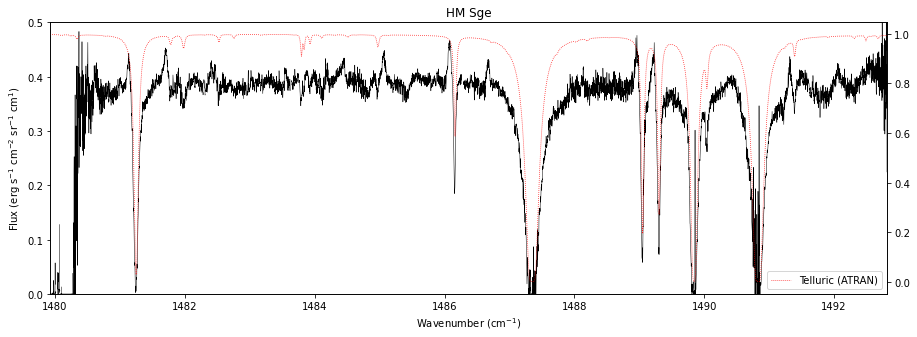

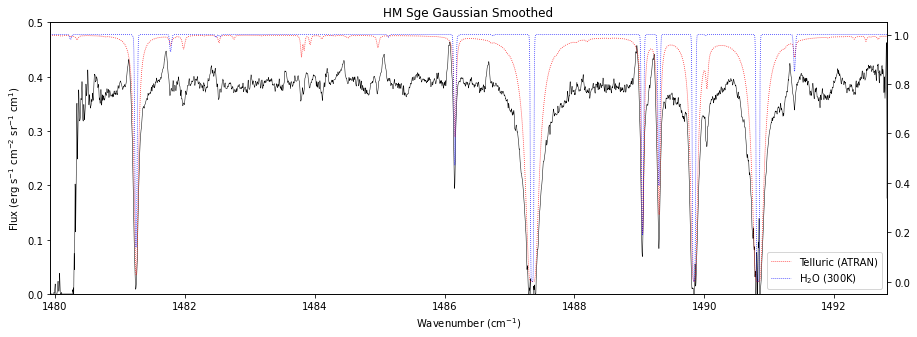

In [8]:
#Original Plot

#Data columns to variables with units
wavenumber = hduList[0].data[0].view()
flux_unit = u.erg * u.s ** (-1) * (u.cm) ** -2 * u.sr ** (-1)
flux = hduList[0].data[1].view()
original_flux = flux.view() * flux_unit
uncertainty = hduList[0].data[2].view() * flux_unit
atran = hduList[0].data[3].view()

#Gaussian smooth the data to visually highlight peaks
variance = 2
g = Gaussian1DKernel(stddev=variance)
gauss_flux = convolve(flux, g)

#Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber,  flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax1.set_xlim(min(wavenumber), max(wavenumber))
ax1.set_ylim(0, .5)
plt.legend()
plt.title("HM Sge")
plt.show()

#Plot the smoothed version
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber,  gauss_flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax2.plot(
        water_model["wavenumber"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
ax1.set_xlim(min(wavenumber), max(wavenumber))
ax1.set_ylim(0, .5)
plt.legend()
plt.title("HM Sge Gaussian Smoothed")
plt.show()

In [9]:
print(max(wavenumber))
print(min(wavenumber))

1492.8154296875
1479.922119140625


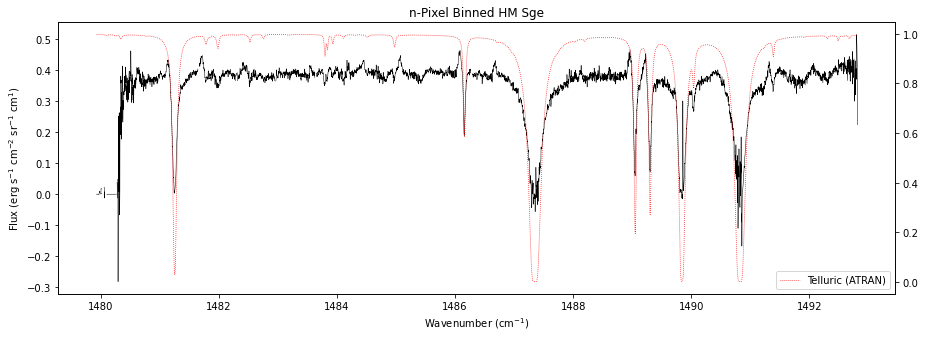

In [10]:
#n Data Point Binning

bin_flux = flux.view()

n = 3 #number of data points in each bin
y = 0 #indexing value for outer loop
x = 0 #indexing value for inner loops
while y < (flux.size-n):
    total = 0
    avg = 0
    while x < n:
        total += bin_flux[y+x]
        x+=1
    avg = total/n
    x-=1
    while x > 0:
        bin_flux[y+x] = avg
        x-=1
    y+=n

#Adds units to newly created variable
bin_flux = bin_flux * flux_unit

#Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber, bin_flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
plt.legend()
plt.title("n-Pixel Binned HM Sge")
plt.show()

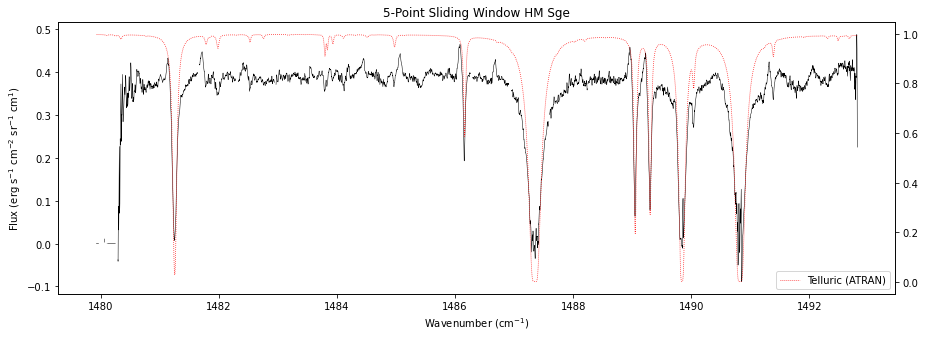

In [11]:
#5-Point Sliding Window Smoothing

sliding_flux=[flux[0],flux[1]]

#Average each value in a sliding window
y = 2 #indexing value for outer loop
while y < (flux.size-2):
    sliding_flux.append((flux[y-2]+flux[y-1]+flux[y]+flux[y+1]+flux[y+2])/5)
    y+=1

sliding_flux.append(flux[flux.size-1])
sliding_flux.append(flux[flux.size-2])

#Adds units to newly created variable
sliding_flux = sliding_flux * flux_unit

#Plot the whole spectrum
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(1, 1, 1)
ax2 = ax1.twinx()
ax1.plot(wavenumber, sliding_flux, lw=0.5, c="k")
ax2.plot(wavenumber, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)")
ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
ax1.set_xlabel(r"Wavenumber (cm$^{-1}$)")
plt.legend()
plt.title("5-Point Sliding Window HM Sge")
plt.show()

In [12]:
#Function to set up the plots

#Convert wavenumber to wavelength
wavelength_um = 1 / wavenumber * 1e4  #convert wavenumber (cm^-1) to wavelength in um

#correction velocity
v_corrected = 13.21 #from exes velocity shift program

#correct for system velocities in the graph
#watergraph = water_model["wavelength_um"]*(v_corrected/300000) + water_model["wavelength_um"]
watergraph = water_model["wavelength_um"]

#Flux smoothing
flux = gauss_flux

def plot_window(xmin, xmax):
    #Create axes
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 1, 1)
    #create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    #hide axis labels and ticks
    ax2.set_yticks([])
    #plot data
    ax1.plot(wavelength_um, flux, lw=0.5, c="k")
    #plot Atmospheric model (ATRAN)
    ax2.plot(
        wavelength_um, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)"
    )

    #Setup water model plot
    ax2.plot(
        water_model["wavelength_um"],
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )

    #Plot labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")

    ax1.set_xlim(xmin, xmax)

    plt.legend(loc="lower right")
    plt.title("HM Sge 12-21")
    return fig, ax1, ax2

#Min and max flux
print(min(flux))
print(max(flux))

-0.057563083415878145
0.4637077770748697


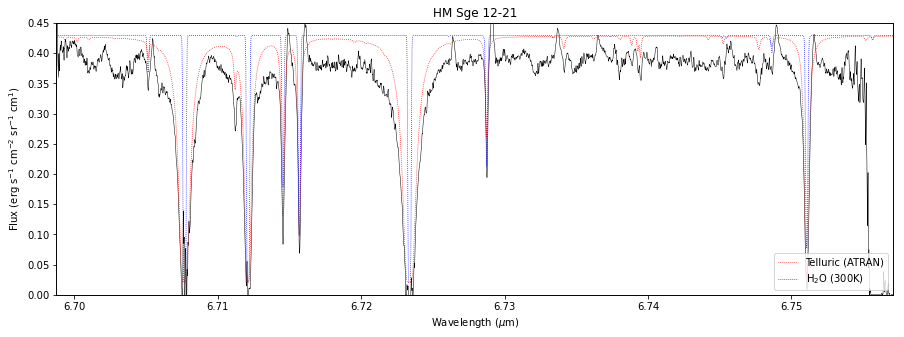

In [13]:
#Plot the full spectrum
minW = min(wavelength_um)
maxW = max(wavelength_um)

#Calls the previously created plot_window function and plots the full range of the data set
fig, ax1, ax2 = plot_window(minW, maxW) 

#Optional manual y range
ax1.set_ylim(0, .45) 

plt.show()

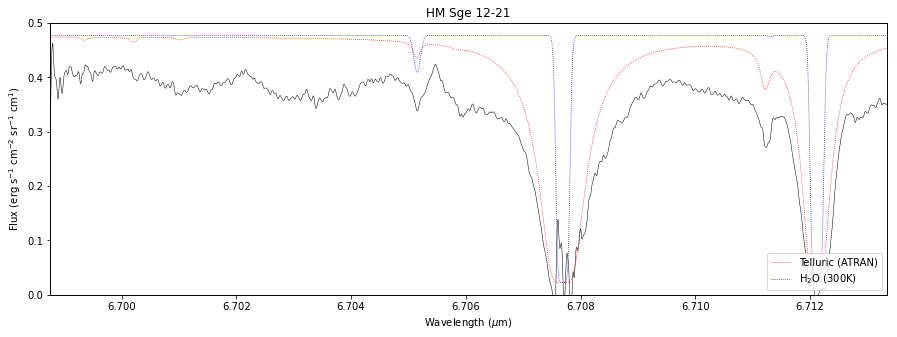

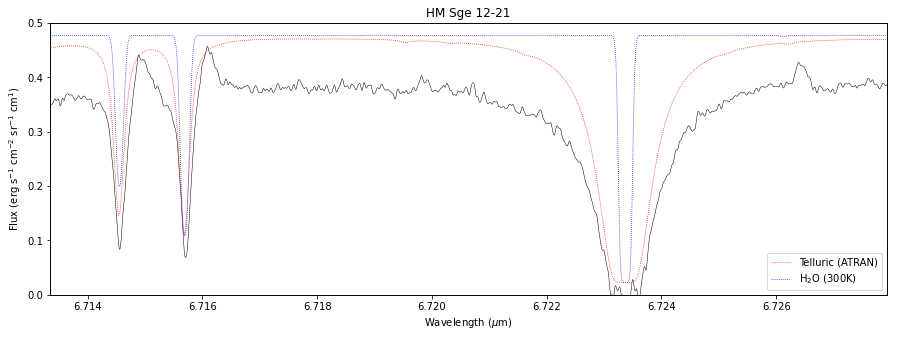

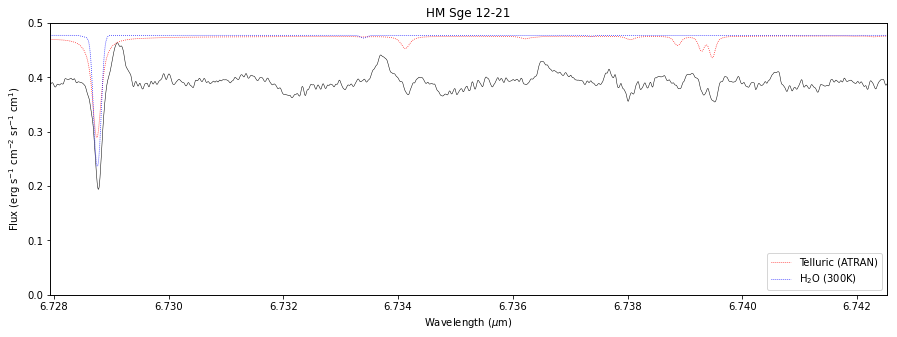

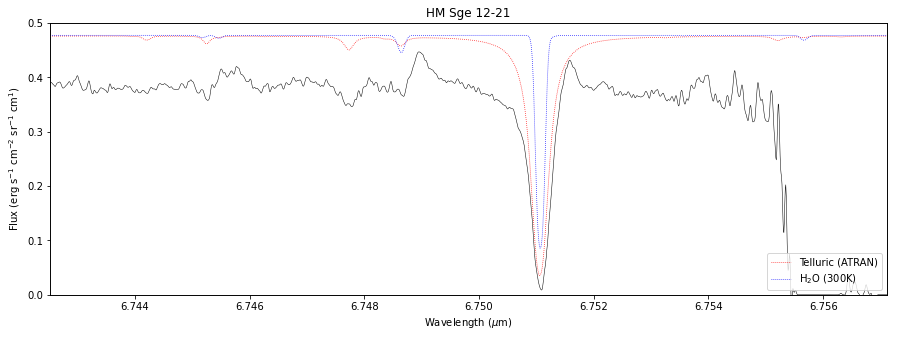

In [14]:
#Zoom in on m divisions of the spectrum

m = 4 #number of seperate plots
j = 0 #indexing value
frac = (maxW - minW)/m #width of each plot
while j < m:
    fig, ax1, ax2 = plot_window(minW + j*frac, minW + (j+1)*frac)
    ax1.set_ylim(0, .5) 
    plt.show()
    j+=1

In [15]:
#Flux peaks

fluxPeakIndices, _ = sp.find_peaks(flux, height=.41, distance = 50)
print(fluxPeakIndices)

fluxPeakWavelengths = wavelength_um[fluxPeakIndices]
print(fluxPeakWavelengths)

examplePeakWavelength = []



#Find notable features and programmatically determine their values

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[8]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[12]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[2]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[1]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-7]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[-8]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[7]])

examplePeakWavelength.append(wavelength_um[fluxPeakIndices[9]])

examplePeakWavelength.sort()

exampleIndicies = []
examplePeakValues = []
print("Wavelengths of Peaks in Order:", examplePeakWavelength)

for x in examplePeakWavelength:
    exampleIndicies.append(np.where(wavelength_um == x))

for x in exampleIndicies:
    examplePeakValues.append(flux[x][0])

print("Heights of Peaks in Order:", examplePeakValues)

[ 324  673  993 1380 2008 2368 2512 2853 3413 3745 5005 5151 6305 6711
 6919 6973 7053 7124]
[6.75445312 6.75158176 6.74895137 6.7457736  6.74062262 6.73767434
 6.73649531 6.73369731 6.7291064  6.72638855 6.71608796 6.7148906
 6.70547032 6.70216337 6.70046125 6.70002174 6.69937026 6.6987923 ]
Wavelengths of Peaks in Order: [6.705470319740105, 6.714890597776086, 6.716087957468931, 6.726388545170507, 6.729106399805684, 6.733697313565481, 6.748951366852136, 6.751581763245796]
Heights of Peaks in Order: [0.4242526130713271, 0.44112328984321564, 0.45709780325663485, 0.4275479517344743, 0.4637077770748697, 0.4411746761729645, 0.4468581783915003, 0.4314500828461151]


In [16]:
#Water Troughs

water_model = np.transpose(water_model)

#print(water_model)
water = (-1*water_model["flux"])+1
#print(water)
waterTroughIndices, _ = sp.find_peaks(water, height = .001,distance = 50)
#print(waterTroughIndices)
waterTroughFlux = water[waterTroughIndices]
#print(waterTroughFlux)
waterPeakWavelength = water_model["wavelength_um"][waterTroughIndices]
#print(waterPeakWavelength)

exampleWaterWL=[]

#Find notable features and programmatically determine their values
for wl in waterPeakWavelength:
    if((wl> 6.728) & (wl < 6.730)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.704) & (wl < 6.7055)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.748) & (wl < 6.749)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.714) & (wl < 6.715)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.715) & (wl < 6.716)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.732) & (wl < 6.734)):
        exampleWaterWL.append(wl)
        break

for wl in waterPeakWavelength:
    if((wl> 6.7255) & (wl < 6.7265)):
        exampleWaterWL.append(wl)
        break
    
for wl in waterPeakWavelength:
    if((wl> 6.750) & (wl < 6.752)):
        exampleWaterWL.append(wl)
        break

#Sort water values
exampleWaterWL.sort()

exampleWaterIndicies = []
waterTroughVals = []

#Find the indicies of the notable water features
for x in exampleWaterWL:
    exampleWaterIndicies.append([np.where(water_model["wavelength_um"] == x)])
print(exampleWaterIndicies[0][0][0])

print(exampleWaterWL)

[73562]
[6.705157498121694, 6.714551801709945, 6.715689805382479, 6.726113999313431, 6.728763391578174, 6.733396003653518, 6.7486472265773525, 6.75106537600672]


In [17]:
#Velocity calculation

#correction velocity
v_corrected = 13.21 #from exes velocity shift program

#convert to m
fluxPeakWL = [EmissionWL * 10**-6 for EmissionWL in examplePeakWavelength]
waterTroughWL = [WaterWL *10**-6 for WaterWL in exampleWaterWL]

#difference of each water trough and flux peak
diff = list()
for w1, w2 in zip(fluxPeakWL, waterTroughWL):
    diff.append(w1-w2)

#velocity calculation
c = 3*(10**8)
totV = []
i = 0
while i < len(diff):
    totV.append(((diff[i]/waterTroughWL[i]) * c) /1000) #convert to km/s
    i+=1

correctedV = [x - v_corrected for x in totV]

print("Corrected velocities of lines = ",correctedV, "km/s")

Corrected velocities of lines =  [0.7861642287323427, 1.9270966884780627, 4.576054656629459, -0.9646296224971049, 2.08292416221429, 0.21457409900590463, 0.3100551120377997, 9.736922166313608] km/s


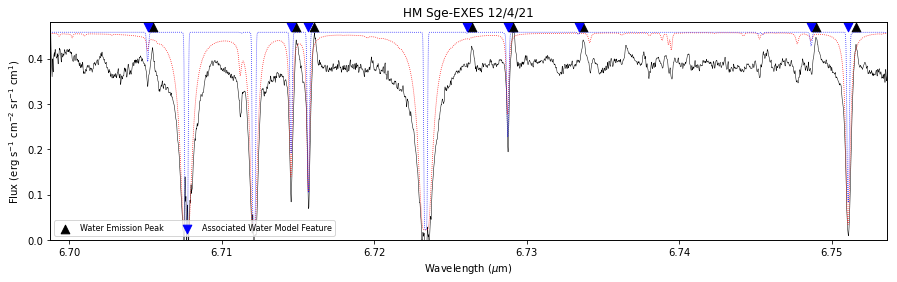

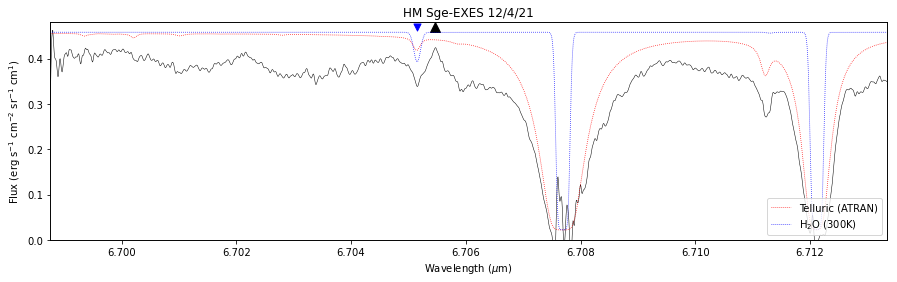

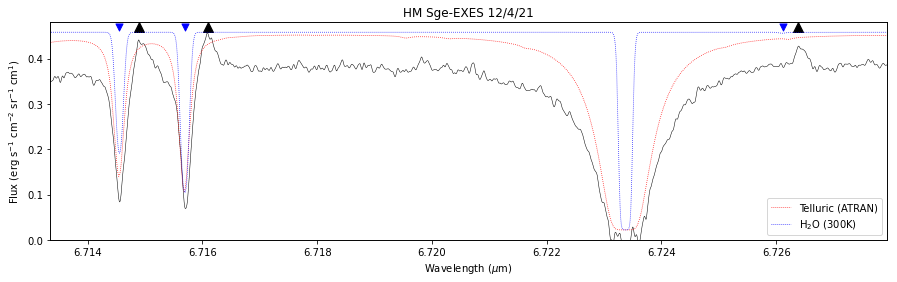

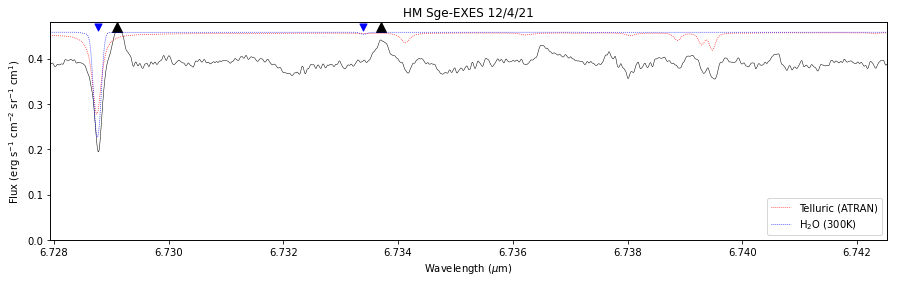

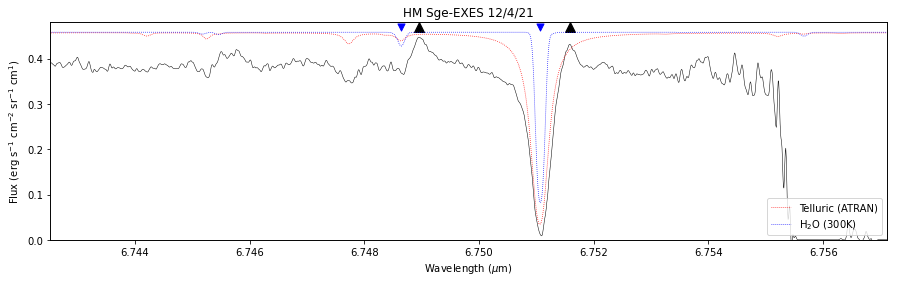

In [18]:
#correct for system velocities in the graph
#watergraph = water_model["wavelength_um"]*(v_corrected/300000) + water_model["wavelength_um"]
watergraph = water_model["wavelength_um"]

#Flux smoothing
flux = gauss_flux

def plot_window(xmin, xmax):
    #Create axes
    fig = plt.figure(figsize=(15, 4))
    ax1 = fig.add_subplot(1, 1, 1)
    #create second axis to overplot ATRAN
    ax2 = ax1.twinx()
    #hide axis labels and ticks
    ax2.set_yticks([])
    #plot data
    ax1.plot(wavelength_um, flux, lw=0.5, c="k")
    #plot Atmospheric model (ATRAN)
    ax2.plot(
        wavelength_um, atran, lw=0.75, c="r", linestyle=":", label="Telluric (ATRAN)"
    )

    #Setup water model plot
    ax2.plot(
        watergraph,
        water_model["flux"],
        lw=0.75,
        c="b",
        linestyle=":",
        label=r"H$_2$O (300K)",
    )

    #Plot labels
    ax1.set_ylabel(r"Flux (erg s$^{-1}$ cm$^{-2}$ sr$^{-1}$ cm$^{1}$)")
    ax1.set_xlabel(r"Wavelength ($\mu$m)")

    ax1.set_xlim(xmin, xmax)

    plt.legend(loc="lower right")
    plt.title("HM Sge-EXES 12/4/21")
    return fig, ax1, ax2

#Calls the previously created plot_window function and plots the full range of the data set
fig, ax1, ax2 = plot_window(minW, maxW-.0035)

#Optional manual y range
ax1.set_ylim(0, .48) 

#marks the features on the plot
pointers = np.full(len(examplePeakWavelength),.47)

emission = ax1.scatter(examplePeakWavelength, pointers, s=75, c = "black", marker = "^")
trough = ax1.scatter(exampleWaterWL, pointers, s=75, c = "blue", marker = "v")

plt.legend((emission, trough),
           ('Water Emission Peak', "Associated Water Model Feature"),
           scatterpoints=1,
           loc='lower left',
           ncol=3,
           fontsize=8)

plt.show()

#Zoom in on m divisions of the spectrum

m = 4 #number of seperate plots
j = 0 #indexing value
frac = (maxW - minW)/m #width of each plot
while j < m:
    fig, ax1, ax2 = plot_window(minW + j*frac, minW + (j+1)*frac)
    ax1.set_ylim(0, .48) 
    pointers = np.full(len(examplePeakWavelength),.47)
    emission = ax1.scatter(examplePeakWavelength, pointers, s=100, c = "black", marker = "^")
    trough = ax1.scatter(exampleWaterWL, pointers, s=50, c = "blue", marker = "v")
    plt.show()
    j+=1

[0.06705157 0.06714552 0.0671569  0.06726114 0.06728763 0.06733396
 0.06748647 0.06751065]
[139.28242655403452, 141.39329377664242, 139.78855806335682, 138.87784372470912, 139.6642790047628, 140.46892384607267, 141.61723143742114, 141.80389548658366]
[4421.00808180155, 3268.51683220775, 3590.01964166812, 5581.55030673038, 3867.5825239234905, 4881.4538991544705, 3977.8190455242902, 2912.33066035542]
[-8.87801919e-04  1.43968783e+02]
1126.3773801761652


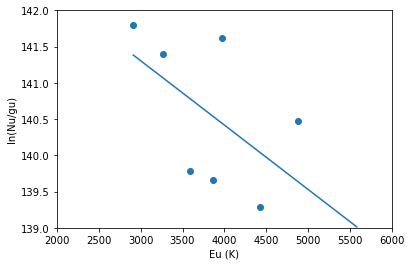

In [19]:
#Use hitran to make rotational diagrams

#Match the water model wavelengths to specific entries in the hitran table
tableWLs = []
for w in exampleWaterWL:
    tableWLs.append((min(hitran["Wavelength"], key=lambda x:abs(x-w))))

#print(tableWLs)

#find the indicies of those entries
tableIndicies = []
for x in tableWLs:
    tableIndicies.append(np.where(hitran["Wavelength"] == x)[0][0])

#print(tableIndicies)

#convert to meters
waterWavelengthMeters =  np.dot(1/100,exampleWaterWL)
print(waterWavelengthMeters)

#Calculate the # of emitting molecules (Nu)
Nu = []
d = 3.2166*10**19 #distance (m)
i = 0
for x in tableIndicies:
    num = 4*math.pi*examplePeakValues[i]*(d**2)*waterWavelengthMeters[i]
    den = 3*(10**8)*hitran["A"][x]*6.62607015*(10**(-34))
    Nu.append(num/den)
    i=i+1

#Retrieve upper degeneracy from hitran
gu = []
for x in tableIndicies:
    gu.append(hitran["gu"][x])

#Retrieve upper energy from hitran
Eu = []
for x in tableIndicies:
    Eu.append(hitran["Eu(K)"][x])

#print(Nu)
#print(gu)

#Calculate the number of emitting molecules over the upper state degeneracy
numDegen = []
j = 0
for x in Nu:
    z = Nu[j]/gu[j]
    numDegen.append(math.log(z))
    j=j+1

print(numDegen)
print(Eu)

x = Eu
y = numDegen
plt.scatter(x, y)
plt.ylabel("ln(Nu/gu)")
plt.xlabel("Eu (K)")
plt.xlim([2000, 6000])
plt.ylim([139,142])

#fit a line to the data to find temperature
mb = np.polyfit(x, y, 1)
print(mb)
m = -1/mb[0]
print(m)
plt.plot(np.unique(x), np.poly1d(mb)(np.unique(x)))
plt.show()

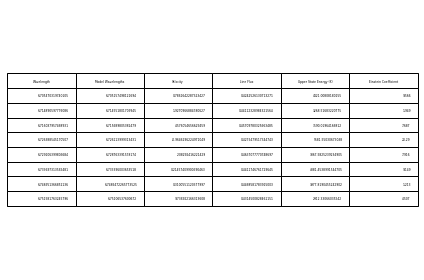

In [20]:
#Tabulated values to include with paper

#define figure and axes
fig, ax = plt.subplots()

#hide the axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

#obDate = ["4/27/22", "","","",]

A = []
for x in tableIndicies:
    A.append(hitran["A"][x])
#create data
df = pd.DataFrame(np.transpose([examplePeakWavelength,  exampleWaterWL, correctedV, examplePeakValues, Eu, A]), columns=["Wavelength", "Model Wavelengths", "Velocity", "Line Flux", "Upper State Energy (K)", "Einstein Coefficient"])

#create table
table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')

#display table
fig.tight_layout()
plt.show()

df.to_csv('12_21.csv')